# A Score-based Generative Model on 2D Gaussian data  

We will use a simple 2D Gaussian dataset to illustrate the geometry of scores learned by a Score-based Generative Model (SGM).  

Specifically we investigate if the score learned automatically incoporates the geometric information, that is, we compare the samples generated by the SGM with the samples generated by a preconditioned Langevin sampler using true score.  

The data is drawn from $\mathcal{N}(\mu, \Sigma)$, where $\mu = [0, 0]$ and $\Sigma = \begin{bmatrix} 1 & 0.9 \\ 0.9 & 1 \end{bmatrix}$. 

In [3]:
import jax
import diffusionjax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from configs import gaussian

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-10-06 14:26:00.895110: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Text(0.5, 1.0, 'Gaussian samples')

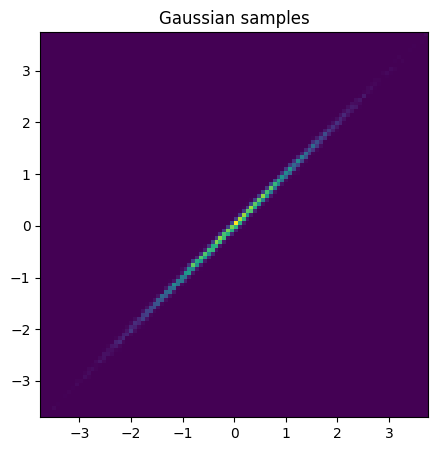

In [4]:
mu = jnp.array([0.0, 0.0])
sigma = jnp.array([[1., 1-1e-3], 
                    [1-1e-3, 1.]])
N = 10000
samples = stats.multivariate_normal.rvs(mean=mu, cov=sigma, size=N)
plt.figure(figsize=(5, 5))
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);
plt.title("Gaussian samples")

In [11]:
from diffusionjax.run_lib import get_model, train, get_solver
from diffusionjax.utils import get_score, get_sampler, get_inpainter
from diffusionjax.plot import (plot_samples, plot_score,
                               plot_heatmap, plot_scatter)
from jax import vmap, grad, jit, random
from jax.scipy.special import logsumexp
from diffusionjax.sde import VP, VE

In [8]:
num_epochs = 4000
num_samples = N
N = samples.shape[1]
rng = random.PRNGKey(2023)

In [12]:
# Get variance preserving (VP) a.k.a. time-changed Ohrnstein Uhlenbeck (OU) sde model
sde = VP()

def log_hat_pt(x, t):
    """
    Empirical distribution score.

    Args:
    x: One location in $\mathbb{R}^2$
    t: time
    Returns:
    The empirical log density, as described in the Jupyter notebook
    .. math::
        \hat{p}_{t}(x)
    """
    mean, std = sde.marginal_prob(samples, t)
    potentials = jnp.sum(-(x - mean)**2 / (2 * std**2), axis=1)
    return logsumexp(potentials, axis=0, b=1/num_samples)

# Get a jax grad function, which can be batched with vmap
nabla_log_hat_pt = jit(vmap(grad(log_hat_pt), in_axes=(0, 0), out_axes=(0)))


In [ ]:
# Neural network training via score matching
from diffusionjax.models import MLP
from diffusionjax.utils import retrain_nn, get_loss, update_step, optimizer
from diffusionjax.solvers import EulerMaruyama

batch_size=16
score_model = MLP()
# Initialize parameters
params = score_model.init(rng, 
                          jnp.zeros((batch_size, N)), 
                          jnp.ones((batch_size,)))
# Initialize optimizer
opt_state = optimizer.init(params)
# Get loss function
solver = EulerMaruyama(sde)
loss = get_loss(
    sde, solver, score_model, score_scaling=True, likelihood_weighting=False)
# Train with score matching
score_model, params, opt_state, mean_losses = retrain_nn(
    update_step=update_step,
    num_epochs=num_epochs,
    step_rng=rng, # random key
    samples=samples, 
    params=params,
    opt_state=opt_state,
    loss=loss,
    batch_size=batch_size)
# Get trained score
trained_score = get_score(sde, score_model, params, score_scaling=True)